# COVID19 Classification from Chest xrays
The objective of this project is to classify xray images and identify the ones that have stronger possibility of COVID vs Normal. Label 0 is assigned if there is no Covid and label 1 is assigned when there is Covid. A quick and accurate detection is very crucial here and a false negative detection (Actually has Covid but prediction as Normal) will prove to be a major disaster even fatal. The classification will be done through custom CNN models as well as Transfer Learning

GitHub Link: https://github.com/suchig/DTSA-5511-Final

## Data
Data is provided by Kaggle https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This database has 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images and corresponding lung masks. **For this work, only Normal and Covid based xrays are considered**

The data contains various files. The files of concern for this project are

COVID - Folder containing images pertaining COVID xrays\
Normal - Folder containing images pertaining to Normal xrays

In [47]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from keras.applications.vgg19 import VGG19
from keras.applications.efficientnet import EfficientNetB3
import pickle
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.cm as cm

### EDA, Data Cleaning and Feature Engineering

In [2]:
base_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

print(os.listdir(base_path))

['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


Read file names, create path, tabulate them as covid or normal

In [3]:

sub_path = {"COVID":1, "Normal":0}

tracking_list = []
for sub_path_name, value in sub_path.items():
    path_list = [os.path.join(base_path,sub_path_name,"images",item) 
                 for item in os.listdir(os.path.join(base_path,sub_path_name,"images"))]
    name_list = [item.split("/")[-1] for item in path_list]
    is_covid_list = [sub_path[sub_path_name] for i in range(len(name_list))]
    is_covid_desc_list = [sub_path_name for i in range(len(name_list))]
    tracking_list.extend([[name, path, is_covid_desc, is_covid] for name, path, is_covid_desc, is_covid in 
                          zip(name_list, path_list, is_covid_desc_list, is_covid_list)])
track_df = pd.DataFrame(tracking_list, columns=["image","path","is_covid_desc","is_covid"])
track_df.sample(10)

,image,path,is_covid_desc,is_covid
7826,Normal-7169.png,../input/covid19-radiography-database/COVID-19...,Normal,0
805,COVID-2893.png,../input/covid19-radiography-database/COVID-19...,COVID,1
1132,COVID-2353.png,../input/covid19-radiography-database/COVID-19...,COVID,1
5339,Normal-6107.png,../input/covid19-radiography-database/COVID-19...,Normal,0
2224,COVID-541.png,../input/covid19-radiography-database/COVID-19...,COVID,1
9316,Normal-4878.png,../input/covid19-radiography-database/COVID-19...,Normal,0
13108,Normal-942.png,../input/covid19-radiography-database/COVID-19...,Normal,0
13480,Normal-926.png,../input/covid19-radiography-database/COVID-19...,Normal,0
6207,Normal-7731.png,../input/covid19-radiography-database/COVID-19...,Normal,0
2535,COVID-2675.png,../input/covid19-radiography-database/COVID-19...,COVID,1


#### Is the data imabalanced?
Looking at the below, we see that COVID xrays are 25% and Normal files are 75%. This is imbalanced. But since there is very little set of files, we will go ahead and proceed to use this as is.

In [4]:
print(track_df["is_covid_desc"].value_counts())

is_covid_desc
Normal    10192
COVID      3616
Name: count, dtype: int64


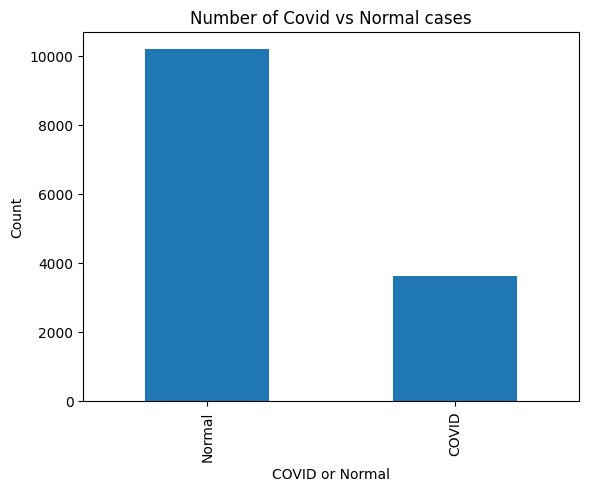

In [5]:
track_df["is_covid_desc"].value_counts()\
.plot(kind="bar", title="Number of Covid vs Normal cases", xlabel="COVID or Normal", ylabel="Count");

Each image is 299x299 in size

In [6]:
pil_image = Image.open(track_df.sample(1)["path"].values[0],).convert('RGB')
print(f"Image shape: {np.array(pil_image).shape}")

Image shape: (299, 299, 3)


#### Visualize the COVID and Normal images

For a layman it is very hard to distinguish the difference between COVID xray vs a normal xray. But we will see how our model will be able to make this distinction

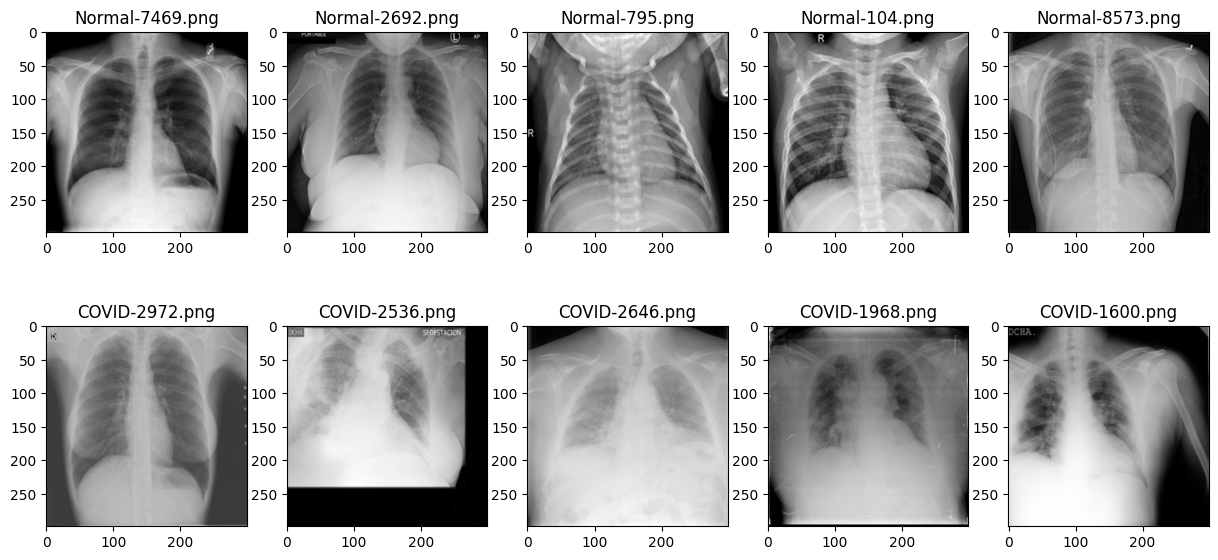

In [7]:
fig = plt.figure(figsize=(15, 7))
rows = 2
columns = 5

normal_df = track_df[track_df["is_covid"]==0].sample(5)

for i, (image, path) in enumerate(zip(normal_df["image"], normal_df["path"])):
    fig.add_subplot(rows, columns, i+1)
    pil_image = Image.open(path).convert('L')
    plt.imshow(np.asarray(pil_image), cmap=plt.get_cmap('gray'))
    plt.title(image)
    
    
covid_df = track_df[track_df["is_covid"]==1].sample(5)

for j, (image, path) in enumerate(zip(covid_df["image"], covid_df["path"])):
    fig.add_subplot(rows, columns, j+6)
    pil_image = Image.open(path).convert('L')
    plt.imshow(np.asarray(pil_image), cmap=plt.get_cmap('gray'))
    plt.title(image)
    
    

#### Feature Engineering
Here the following are done
1. Images are resized to 128x128 to conserve memory 
2. They are normalized by dividing by 255, the maximum value of a pixel
3. They are resized to 128x128
4. They are stored in memory for faster processing
5. The data is split as Train, Validate and Test (70%, 15% and 15% respectively)
6. These are stored as pickle files since storing in memory is a long running process

In [16]:
path_names = track_df["path"].values

X=[]
y = track_df["is_covid"].values

for i, name in enumerate(path_names):
    img = cv2.imread(name) 
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = cv2.resize(img,(128,128)) 
    X.append((img))
X = np.array(X)
y = np.array(y).reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = X_train /255
X_test = X_test / 255
X_val = X_val / 255

In [8]:
# with open("train.pkl","wb") as f:
#     pickle.dump((X_train, y_train),f)
# with open("valid.pkl","wb") as f:
#     pickle.dump((X_val, y_val),f)
# with open("test.pkl","wb") as f:
#     pickle.dump((X_test, y_test), f)
    
with open("../input/pkl-files/train.pkl","rb") as f:
    (X_train, y_train) = pickle.load(f)
with open("../input/pkl-files/valid.pkl","rb") as f:
    (X_val, y_val) = pickle.load(f)
with open("../input/pkl-files/test.pkl","rb") as f:
    (X_test, y_test)= pickle.load(f)

## Models and Training

The following models are tried
1. Custom Model with 1e-3 loss
2. Custom Model with 1e-4 loss
3. VGG16 Model with 1e-5 loss
4. VGG16 Model with 5e-6 loss

#### 1. Custom Model with 1e-3 loss
- This has 3 Convolution layers and finally and Fully connected layer. 
- The final layer is a Sigmoid that will provide a 0 or 1 value.
- Binary Cross entropy is the loss
- Batch size is 64

In [10]:
def make_model(dim):
    inputs = layers.Input(shape=dim)
    x = layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = dim)(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [11]:
model = make_model((128,128,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496 

EarlyStopping is introduced to stop when validation loss stagnates beyond 5 epochs

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer= tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(X_train,y_train,
                        batch_size = 64, 
                        epochs =50,
                        validation_data =(X_val, y_val), 
                        callbacks=[early_stop]
                       )

Epoch 1/50
152/152 [==============================] - 12s 23ms/step - loss: 0.4731 - accuracy: 0.7956 - val_loss: 0.3750 - val_accuracy: 0.8369
Epoch 2/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2744 - accuracy: 0.8856 - val_loss: 0.4239 - val_accuracy: 0.8137
Epoch 3/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2277 - accuracy: 0.9068 - val_loss: 0.3023 - val_accuracy: 0.8567
Epoch 4/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2431 - accuracy: 0.9012 - val_loss: 0.2571 - val_accuracy: 0.9175
Epoch 5/50
152/152 [==============================] - 2s 15ms/step - loss: 0.1799 - accuracy: 0.9310 - val_loss: 0.6615 - val_accuracy: 0.7679
Epoch 6/50
152/152 [==============================] - 2s 15ms/step - loss: 0.1992 - accuracy: 0.9247 - val_loss: 0.2941 - val_accuracy: 0.8904
Epoch 7/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2978 - accuracy: 0.8942 - val_loss: 0.2508 - val_accuracy: 0.915

In [13]:
model.save('cnn_model_1e3.keras')

In [14]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss per epoch Train vs Validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'],loc ='upper left')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy per epoch Train vs Validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'],loc ='upper left')
    plt.show()
    

#### Plots of Loss and Accuracy
Visualizing Loss and Accuracy we see that there are fluctuations, yet Validation loss and accuracy followed similar path as Training

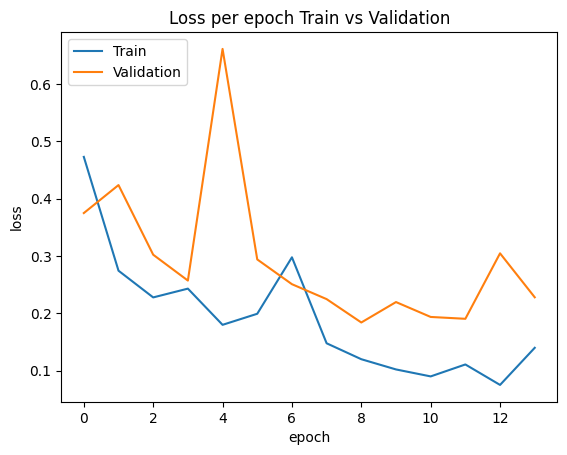

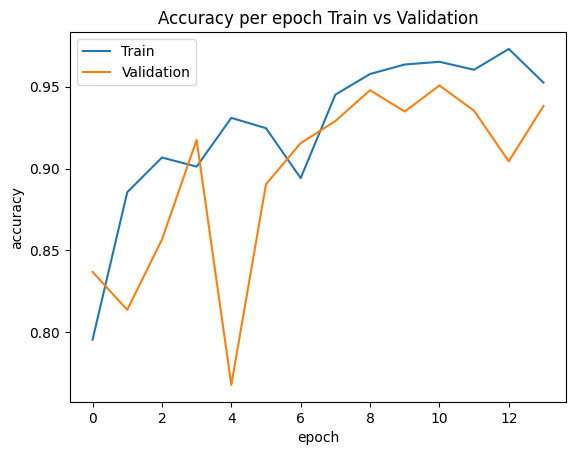

In [15]:
plot_loss_acc(history)

#### Metrics
While Validation data is used to streamline the Training, that is it decides when Training should be stopped, Test data is used to calculate the metrics

In [21]:
def get_predictions(model, X_test):
    predictions = model.predict(X_test)
    predictions[predictions>=0.5] = 1
    predictions[predictions<0.5] = 0
    return predictions

def get_statistics(y_true, y_pred):
    labels = ['Normal', 'Covid']
    report = classification_report(y_true, y_pred, target_names=labels)
    accuracy = accuracy_score(y_true, y_pred)

    return report, accuracy

def display_confusion_matrix(y_true, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["Normal", "COVID"])

65/65 [==============================] - 0s 5ms/step
-------------------Classification Report-----------------
              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95      1531
       Covid       0.83      0.92      0.87       540

    accuracy                           0.93      2071
   macro avg       0.90      0.93      0.91      2071
weighted avg       0.93      0.93      0.93      2071

---------------------------------------------------------
Accuracy Score: 0.9309512312892323


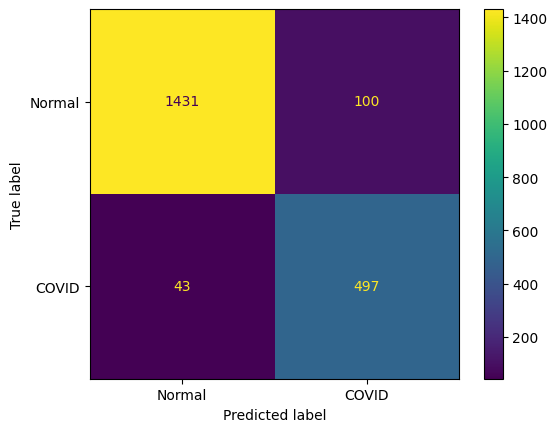

In [28]:
predictions = get_predictions(model, X_test)
report, accuracy = get_statistics(y_test, predictions)
print("-------------------Classification Report-----------------")
print(report)
print("---------------------------------------------------------")
print(f"Accuracy Score: {accuracy}")
display_confusion_matrix(y_test, predictions)

From above we see that 
- Acciracy is 93%. 
- Recall for Covid is 92%. Recall of Covid shows how well COVID is detected without much False Negatives. 
- Hence False negative is 8%

### 2. Custom Model with 1e-4 loss
Maybe reducing the loss will give a better performance

In [17]:
model = make_model((128,128,3))
model.compile(
    optimizer= tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(X_train,y_train,
                        batch_size = 64, 
                        epochs =50,
                        validation_data =(X_val, y_val), 
                        callbacks=[early_stop]
                       )

Epoch 1/50
152/152 [==============================] - 5s 21ms/step - loss: 0.4787 - accuracy: 0.7684 - val_loss: 0.3927 - val_accuracy: 0.8277
Epoch 2/50
152/152 [==============================] - 2s 15ms/step - loss: 0.3457 - accuracy: 0.8469 - val_loss: 0.3286 - val_accuracy: 0.8547
Epoch 3/50
152/152 [==============================] - 2s 15ms/step - loss: 0.3064 - accuracy: 0.8677 - val_loss: 0.2901 - val_accuracy: 0.8736
Epoch 4/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2842 - accuracy: 0.8768 - val_loss: 0.3268 - val_accuracy: 0.8518
Epoch 5/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2757 - accuracy: 0.8839 - val_loss: 0.2900 - val_accuracy: 0.8789
Epoch 6/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2595 - accuracy: 0.8914 - val_loss: 0.2549 - val_accuracy: 0.8943
Epoch 7/50
152/152 [==============================] - 2s 15ms/step - loss: 0.2473 - accuracy: 0.8980 - val_loss: 0.3193 - val_accuracy: 0.8571

In [18]:
model.save('cnn_model_1e4.keras')

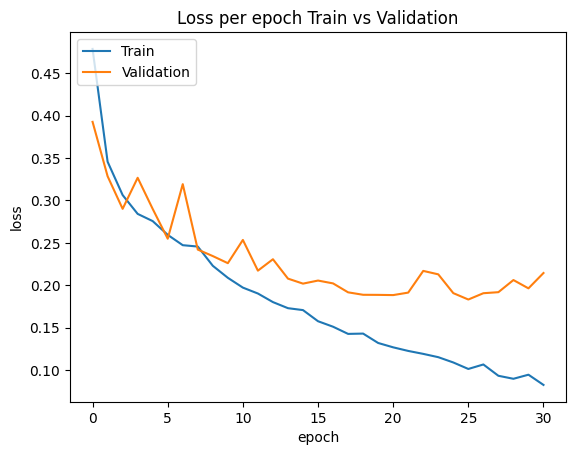

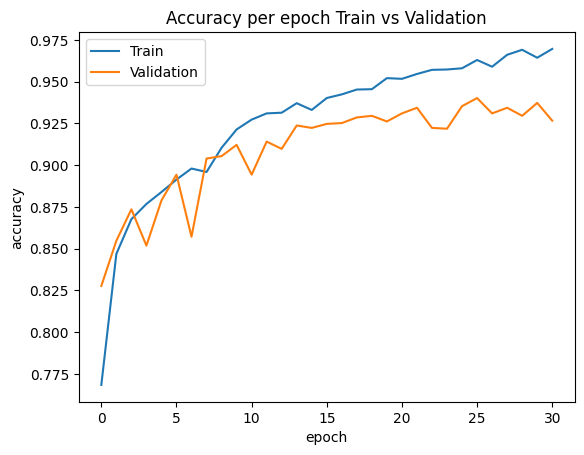

In [19]:
plot_loss_acc(history)

65/65 [==============================] - 0s 5ms/step
-------------------Classification Report-----------------
              precision    recall  f1-score   support

      Normal       1.00      0.55      0.71      1531
       Covid       0.44      0.99      0.61       540

    accuracy                           0.67      2071
   macro avg       0.72      0.77      0.66      2071
weighted avg       0.85      0.67      0.68      2071

---------------------------------------------------------
Accuracy Score: 0.6673104780299373


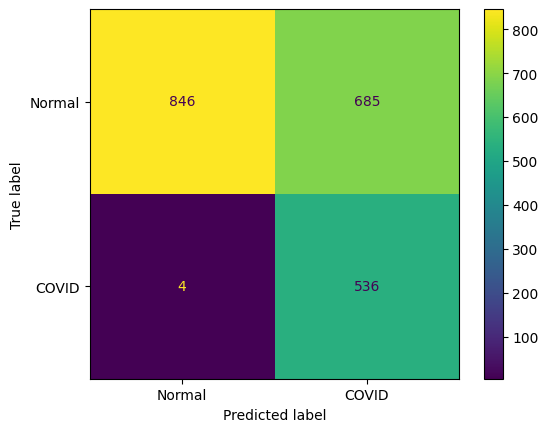

In [22]:
predictions = get_predictions(model, X_test)
report, accuracy = get_statistics(y_test, predictions)
print("-------------------Classification Report-----------------")
print(report)
print("---------------------------------------------------------")
print(f"Accuracy Score: {accuracy}")
display_confusion_matrix(y_test, predictions)

While recall of COVID looks great with 99%, that is there is only 1% False Negative, Accuracy looks very bad with 67%.

### 3. VGG16 Model with loss 1e-5
- VGG Pretrained model is the base layer
- This is followed by 3 Dense layers. The final one is a sigmoid
- Loss is 1e-5

In [41]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

vgg_model = keras.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(1024))
vgg_model.add(layers.Activation("relu"))
vgg_model.add(layers.Dense(512))
vgg_model.add(layers.Activation("relu"))
vgg_model.add(layers.Dense(1))
vgg_model.add(layers.Activation("sigmoid"))

vgg_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              8389632   
                                                                 
 activation_15 (Activation)  (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 activation_16 (Activation)  (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

vgg_model.compile(
    optimizer= tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = vgg_model.fit(X_train,y_train,
                        batch_size=64,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop]
                       )


Epoch 1/50
152/152 [==============================] - 11s 62ms/step - loss: 0.4374 - accuracy: 0.7947 - val_loss: 0.3235 - val_accuracy: 0.8634
Epoch 2/50
152/152 [==============================] - 8s 55ms/step - loss: 0.2739 - accuracy: 0.9036 - val_loss: 0.2510 - val_accuracy: 0.9088
Epoch 3/50
152/152 [==============================] - 8s 55ms/step - loss: 1.9786 - accuracy: 0.9256 - val_loss: 0.2297 - val_accuracy: 0.9204
Epoch 4/50
152/152 [==============================] - 8s 54ms/step - loss: 0.2009 - accuracy: 0.9294 - val_loss: 0.2363 - val_accuracy: 0.9218
Epoch 5/50
152/152 [==============================] - 8s 55ms/step - loss: 0.1805 - accuracy: 0.9381 - val_loss: 0.2246 - val_accuracy: 0.9276
Epoch 6/50
152/152 [==============================] - 8s 55ms/step - loss: 0.1664 - accuracy: 0.9445 - val_loss: 0.2116 - val_accuracy: 0.9315
Epoch 7/50
152/152 [==============================] - 8s 55ms/step - loss: 0.4366 - accuracy: 0.9467 - val_loss: 0.2085 - val_accuracy: 0.925

In [43]:
vgg_model.save('vgg16_1e5.keras')

Looking at the plot below it looks like the Validation Loss was static, however the actual story is that Training loss was fluctuating a lot. This is an indication that loss has to be reduced further

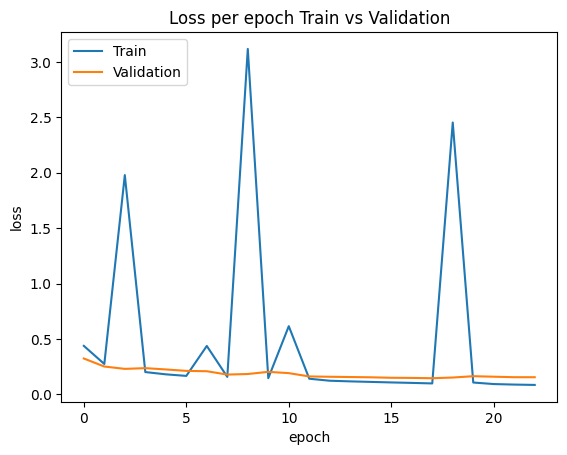

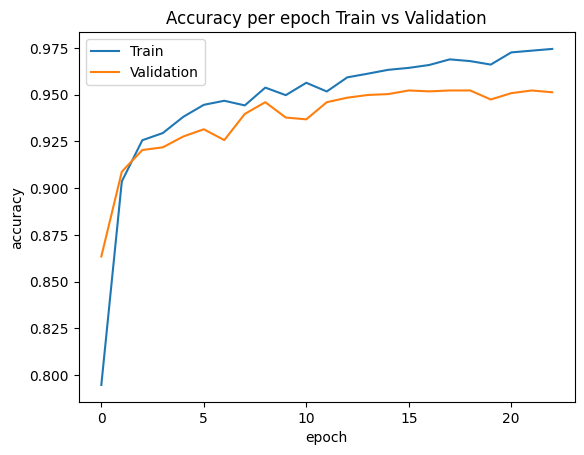

In [44]:
plot_loss_acc(history)

65/65 [==============================] - 2s 23ms/step
-------------------Classification Report-----------------
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      1531
       Covid       0.93      0.89      0.91       540

    accuracy                           0.95      2071
   macro avg       0.95      0.93      0.94      2071
weighted avg       0.95      0.95      0.95      2071

---------------------------------------------------------
Accuracy Score: 0.9531627233220666


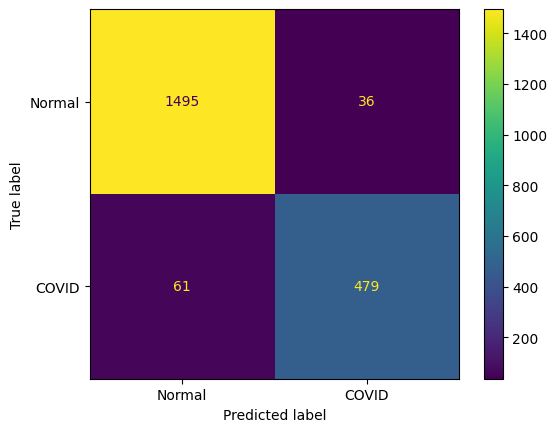

In [45]:
predictions = get_predictions(vgg_model, X_test)
report, accuracy = get_statistics(y_test, predictions)
print("-------------------Classification Report-----------------")
print(report)
print("---------------------------------------------------------")
print(f"Accuracy Score: {accuracy}")
display_confusion_matrix(y_test, predictions)

Above we see that accuracy is better - 95%. But the COVID recall is just around 89%. By reducing loss of VGG 19 we should hope to get better result

### 4. VGG16 model with loss 5e-6 and 100 epochs

In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

vgg_model = keras.Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(1024))
vgg_model.add(layers.Activation("relu"))
vgg_model.add(layers.Dense(512))
vgg_model.add(layers.Activation("relu"))
vgg_model.add(layers.Dense(1))
vgg_model.add(layers.Activation("sigmoid"))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

vgg_model.compile(
    optimizer= tf.keras.optimizers.Adam(5e-6),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = vgg_model.fit(X_train,y_train,
                batch_size=64,
                epochs=100,
                validation_data=(X_val, y_val),
                callbacks=[early_stop]
               )

Epoch 1/100
152/152 [==============================] - 11s 61ms/step - loss: 0.4766 - accuracy: 0.7615 - val_loss: 0.3779 - val_accuracy: 0.8393
Epoch 2/100
152/152 [==============================] - 8s 54ms/step - loss: 0.9228 - accuracy: 0.8677 - val_loss: 0.2996 - val_accuracy: 0.8924
Epoch 3/100
152/152 [==============================] - 8s 54ms/step - loss: 0.2820 - accuracy: 0.8931 - val_loss: 0.2861 - val_accuracy: 0.8991
Epoch 4/100
152/152 [==============================] - 8s 54ms/step - loss: 0.7106 - accuracy: 0.9067 - val_loss: 0.2656 - val_accuracy: 0.9049
Epoch 5/100
152/152 [==============================] - 8s 54ms/step - loss: 0.2399 - accuracy: 0.9120 - val_loss: 0.2486 - val_accuracy: 0.9126
Epoch 6/100
152/152 [==============================] - 8s 54ms/step - loss: 1.1366 - accuracy: 0.9200 - val_loss: 0.2397 - val_accuracy: 0.9175
Epoch 7/100
152/152 [==============================] - 8s 54ms/step - loss: 0.2154 - accuracy: 0.9268 - val_loss: 0.2430 - val_accuracy

In [38]:
vgg_model.save('vgg16_5e6.keras')

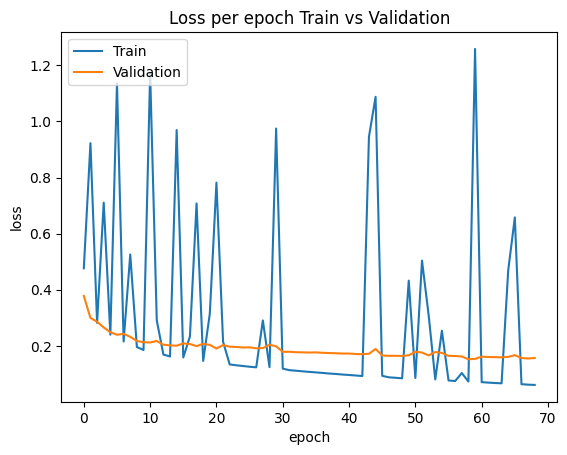

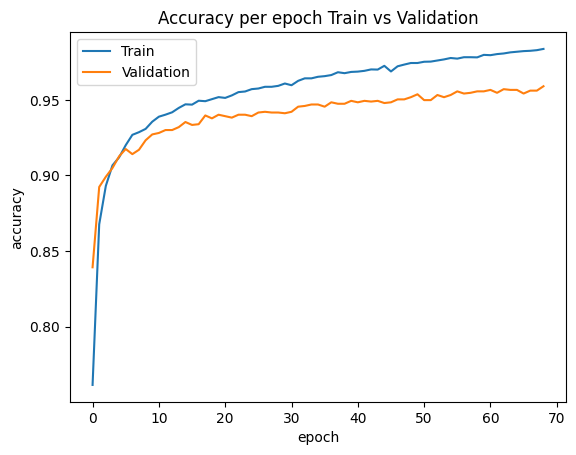

In [39]:
plot_loss_acc(history)

65/65 [==============================] - 2s 23ms/step
-------------------Classification Report-----------------
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      1531
       Covid       0.92      0.91      0.92       540

    accuracy                           0.96      2071
   macro avg       0.94      0.94      0.94      2071
weighted avg       0.96      0.96      0.96      2071

---------------------------------------------------------
Accuracy Score: 0.9560598744567842


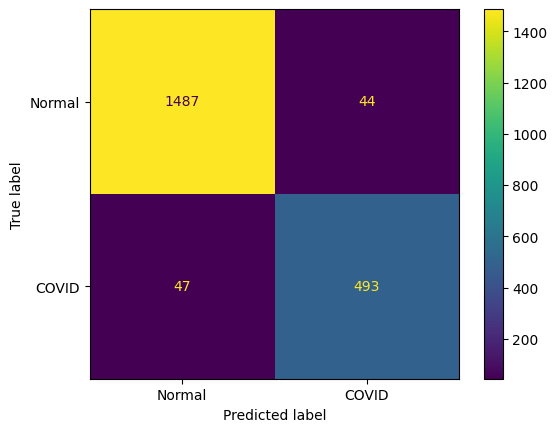

In [40]:
predictions = get_predictions(vgg_model, X_test)
report, accuracy = get_statistics(y_test, predictions)
print("-------------------Classification Report-----------------")
print(report)
print("---------------------------------------------------------")
print(f"Accuracy Score: {accuracy}")
display_confusion_matrix(y_test, predictions)

The accuracy is at 96% and the COVID Recall is 91%. In other words False Positive is 9%

#### Summary
In Summary if accuracy is solely concerned, VGG Model with 5e-6 loss is preferred since it has 96% accuracy. But if Recall is important Custom Model with 1e-4 loss is preferred. 

## Explanability of model

Explainability of model is a huge topic where industry wants to understand why a model decided to predict in a certain way. Deep Learning is a black box and explainability is very hard. One of the ways to show explanability is to show gradients that are more pronounced resulting in a certain sigmoid or classification.
Here we will use Grad CAM (Gradient based Class Activation Mapping) to interpret. The gradients from last convolution layer of VGG-16
based model (block5_pool) is converted to heatmap

In [9]:
#This portion of code pulls random images with true negative, true positive, false negative and false positive
actual_normal = y_test[np.where(y_test==0)]
pred_for_normal = predictions[np.where(y_test==0)]

indices_true_negative = np.where((actual_normal-pred_for_normal) == 0)
indices_false_positive = np.where((actual_normal-pred_for_normal) != 0)

true_negative = X_test[indices_true_negative]
false_positive = X_test[indices_false_positive]

actual_covid = y_test[np.where(y_test==1)]
pred_for_covid = predictions[np.where(y_test==1)]

indices_true_positive = np.where((actual_covid-pred_for_covid) == 0)
indices_false_negative = np.where((actual_covid-pred_for_covid) != 0)

true_positive = X_test[indices_true_positive]
false_negative = X_test[indices_false_negative]

random_tn = true_negative[np.random.choice(range(true_negative.shape[0]),3)]
random_fp = false_positive[np.random.choice(range(false_positive.shape[0]),3)]
random_tp = true_positive[np.random.choice(range(true_positive.shape[0]),3)]
random_fn = false_negative[np.random.choice(range(false_negative.shape[0]),3)]

Display Sample True Negatives

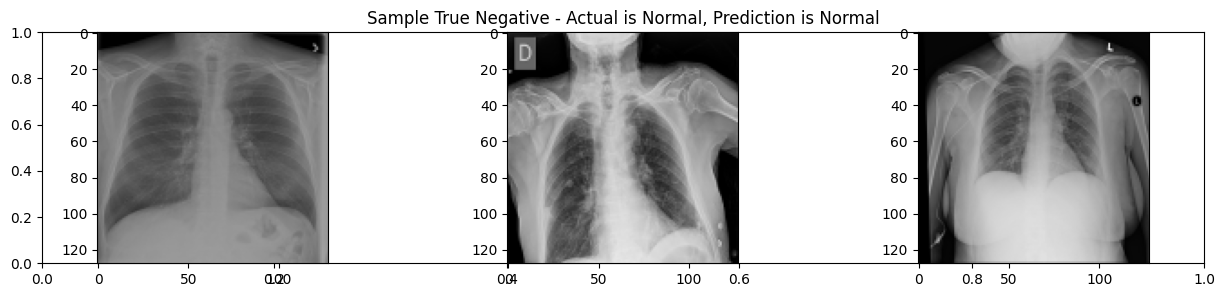

In [137]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample True Negative - Actual is Normal, Prediction is Normal")
for i, image in enumerate(random_tn):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)

Display Sample True Positives

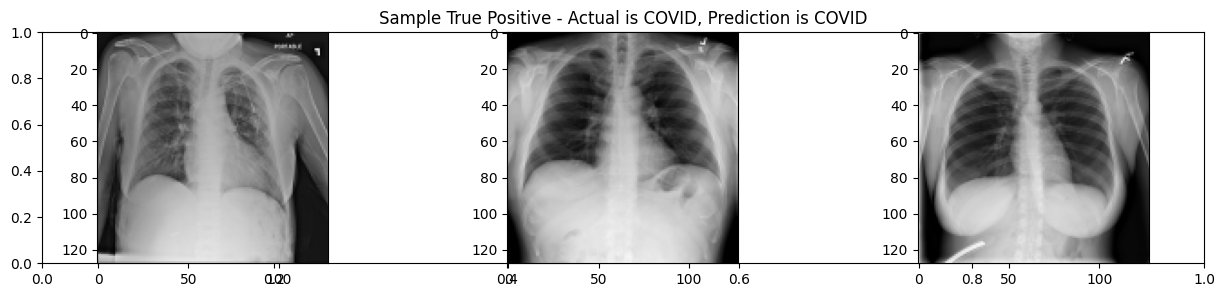

In [138]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample True Positive - Actual is COVID, Prediction is COVID")
for i, image in enumerate(random_tp):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)

Display Sample False Negative

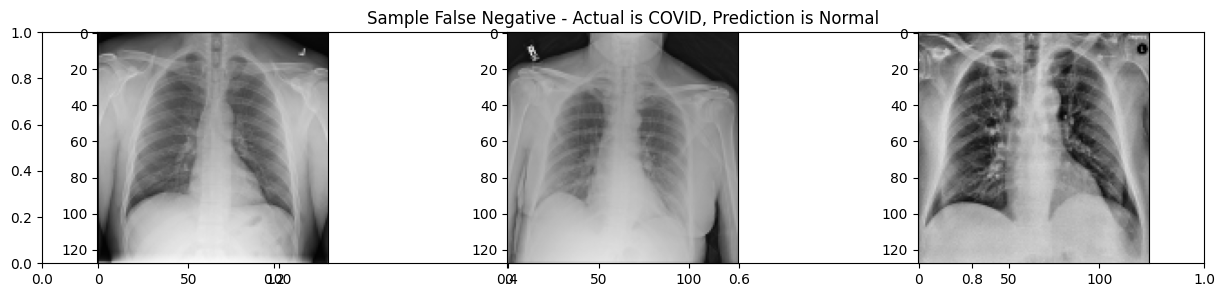

In [139]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample False Negative - Actual is COVID, Prediction is Normal")
for i, image in enumerate(random_fn):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)

Display Sample False Positive

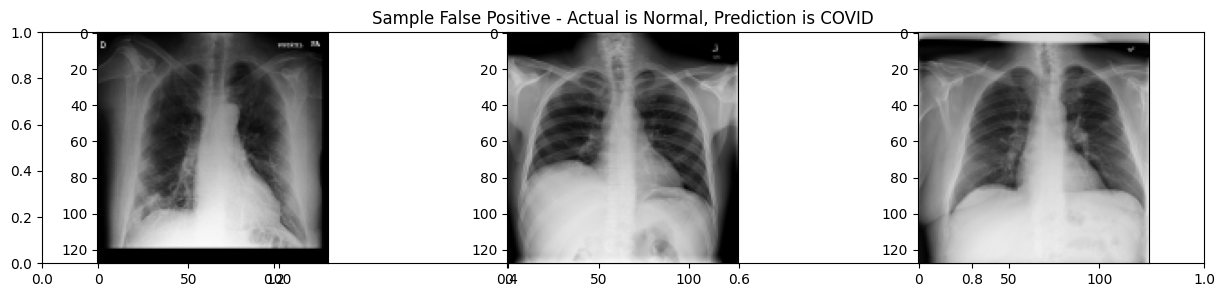

In [140]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample False Positive - Actual is Normal, Prediction is COVID")
for i, image in enumerate(random_fp):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)

Grad Cam Heatmap is created here. Gradients are taken from the last pooled layer and converted into an intesity based heatmap. This shows which areas are considered pronounced by Model Gradients

In [10]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Overlay Heatmap overlays the heatmap on top of the image
Last Layer pulls the last pooled layer

In [11]:
def overlay_heatmap(image, heatmap,  colormap=cv2.COLORMAP_VIRIDIS, alpha=0.4):

    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((128, 128))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img
    
    
def last_layer(model):
    classifier_layers = []
    last_layer = None
    for layer in reversed(model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            last_layer = layer.name
            break
        else:
            classifier_layers.insert(0,layer.name)
    return last_layer, classifier_layers

In [12]:
last_conv_layer_name, classifier_layers = last_layer(vgg_model)

#### Display of all Heatmaps

/tmp/ipykernel_28/3552268627.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


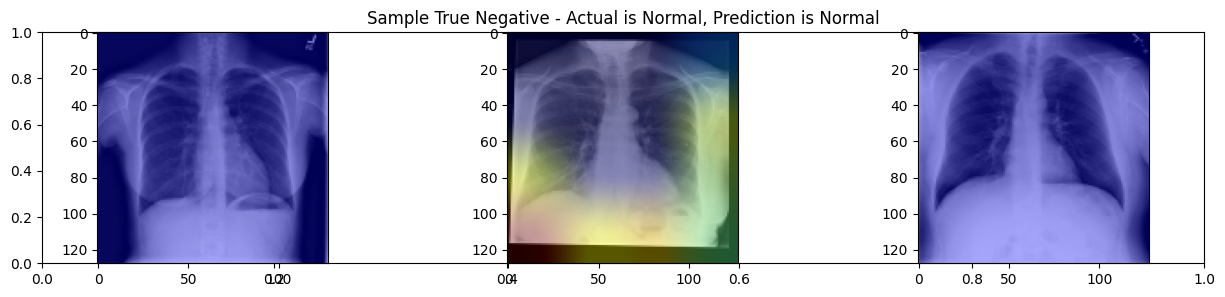

In [13]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample True Negative - Actual is Normal, Prediction is Normal")
for i, image in enumerate(random_tn):
    fig.add_subplot(rows, columns, i+1)
    array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(array, vgg_model, last_conv_layer_name)
    image_processed = np.uint8(255 * image)
    superimposed_image = overlay_heatmap(image_processed, heatmap, alpha=0.5)
    plt.imshow(superimposed_image)

/tmp/ipykernel_28/3552268627.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


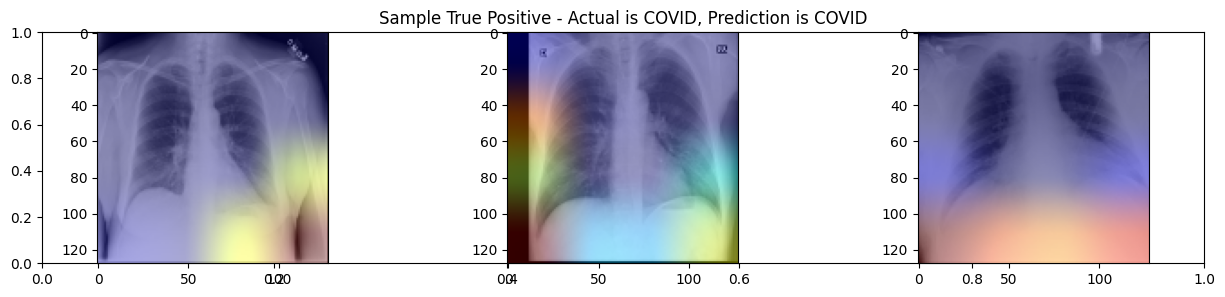

In [14]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample True Positive - Actual is COVID, Prediction is COVID")
for i, image in enumerate(random_tp):
    fig.add_subplot(rows, columns, i+1)
    array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(array, vgg_model, last_conv_layer_name)
    image_processed = np.uint8(255 * image)
    superimposed_image = overlay_heatmap(image_processed, heatmap, alpha=0.5)
    plt.imshow(superimposed_image)

/tmp/ipykernel_28/3552268627.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


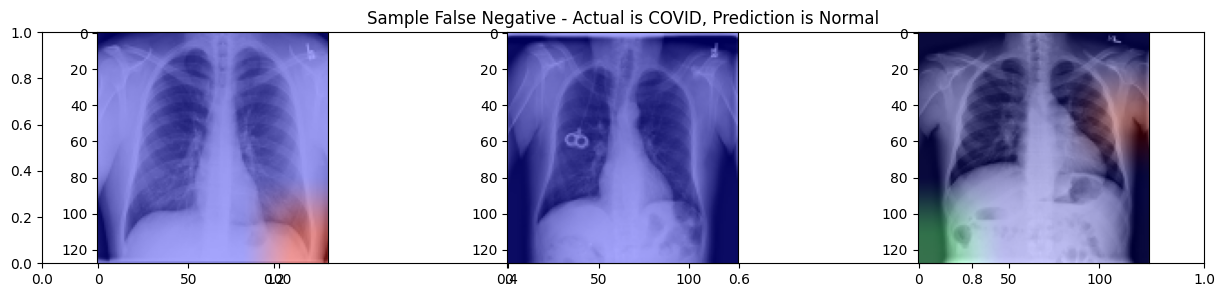

In [15]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample False Negative - Actual is COVID, Prediction is Normal")
for i, image in enumerate(random_fn):
    fig.add_subplot(rows, columns, i+1)
    array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(array, vgg_model, last_conv_layer_name)
    image_processed = np.uint8(255 * image)
    superimposed_image = overlay_heatmap(image_processed, heatmap, alpha=0.5)
    plt.imshow(superimposed_image)

/tmp/ipykernel_28/3552268627.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


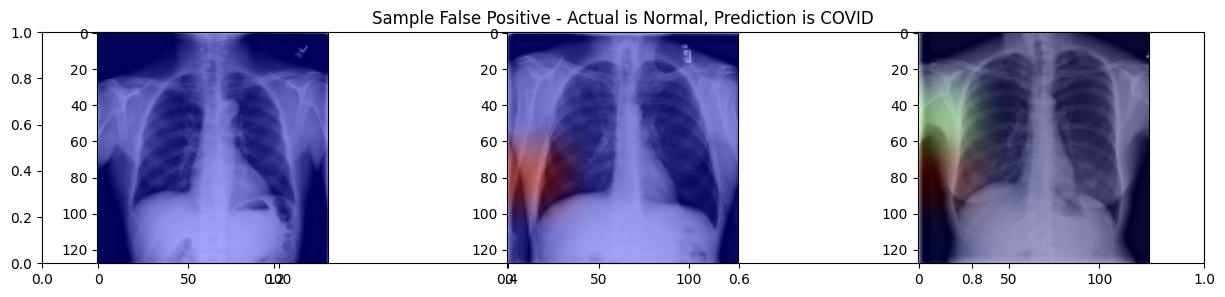

In [16]:
fig = plt.figure(figsize=(15, 3))
rows = 1
columns = 3

plt.title("Sample False Positive - Actual is Normal, Prediction is COVID")
for i, image in enumerate(random_fp):
    fig.add_subplot(rows, columns, i+1)
    array = np.expand_dims(image, axis=0)
    heatmap = make_gradcam_heatmap(array, vgg_model, last_conv_layer_name)
    image_processed = np.uint8(255 * image)
    superimposed_image = overlay_heatmap(image_processed, heatmap, alpha=0.5)
    plt.imshow(superimposed_image)

All the above heatmaps show the areas that are highlighted by Gradients and possibly why it deduced that image to be COVID or Normal

## Conclusion and Lesson Learned
1. More models could have been developed with more hyperparameters. But the challenge was time and resource. I found time spending on Explainability a better one as I learnt a lot from this
2. I moved ahead with moving images to memory. This made it difficult for me to apply augmentations like flip. This could have imporved the result a bit further
3. It looks like Custom Model was better fit for this exercise with Accuracy of 93% and Recall of 92%. But in practice, we will need more complex models with Transfer Learning and with augmentations.
4. Time taken to run a model should also be a factor in deciding the final model. In this case VGG 16 with 5e-6 took close to 20-30 minutes to run. This is small in comparison to practical models which could run for hours. The fial decision should be how good a metric we want and which model can provide the same quickly

## References
1. https://keras.io/examples/vision/grad_cam/